In [1]:
import pandas as pd

In [2]:
df_train = pd.read_csv('train.csv')
df_train

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911
...,...,...,...,...,...,...
26293,26293,2018-12-31,Sweden,KaggleMart,Kaggle Hat,823
26294,26294,2018-12-31,Sweden,KaggleMart,Kaggle Sticker,250
26295,26295,2018-12-31,Sweden,KaggleRama,Kaggle Mug,1004
26296,26296,2018-12-31,Sweden,KaggleRama,Kaggle Hat,1441


In [3]:
df_test = pd.read_csv('test.csv')
df_test

,row_id,date,country,store,product
0,26298,2019-01-01,Finland,KaggleMart,Kaggle Mug
1,26299,2019-01-01,Finland,KaggleMart,Kaggle Hat
2,26300,2019-01-01,Finland,KaggleMart,Kaggle Sticker
3,26301,2019-01-01,Finland,KaggleRama,Kaggle Mug
4,26302,2019-01-01,Finland,KaggleRama,Kaggle Hat
...,...,...,...,...,...
6565,32863,2019-12-31,Sweden,KaggleMart,Kaggle Hat
6566,32864,2019-12-31,Sweden,KaggleMart,Kaggle Sticker
6567,32865,2019-12-31,Sweden,KaggleRama,Kaggle Mug
6568,32866,2019-12-31,Sweden,KaggleRama,Kaggle Hat


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26298 entries, 0 to 26297
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    26298 non-null  int64 
 1   date      26298 non-null  object
 2   country   26298 non-null  object
 3   store     26298 non-null  object
 4   product   26298 non-null  object
 5   num_sold  26298 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.2+ MB


In [5]:
df_train.isnull().sum()

row_id      0
date        0
country     0
store       0
product     0
num_sold    0
dtype: int64

In [6]:
df_train['country'].value_counts()

Finland    8766
Norway     8766
Sweden     8766
Name: country, dtype: int64

In [7]:
df_train['store'].value_counts()

KaggleMart    13149
KaggleRama    13149
Name: store, dtype: int64

In [8]:
df_train['product'].value_counts()

Kaggle Mug        8766
Kaggle Hat        8766
Kaggle Sticker    8766
Name: product, dtype: int64

In [9]:
df_train['date'].value_counts()

2015-01-01    18
2017-09-09    18
2017-09-07    18
2017-09-06    18
2017-09-05    18
              ..
2016-04-30    18
2016-04-29    18
2016-04-28    18
2016-04-27    18
2018-12-31    18
Name: date, Length: 1461, dtype: int64

In [10]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

def prepare_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data['day'] = data['date'].dt.day
    data['day_of_week'] = data['date'].dt.day_of_week
    data['month'] = data['date'].dt.month
    data['year'] = data['date'].dt.year

    cal = calendar()
    holidays = cal.holidays(start=data['date'].min(), end=data['date'].max())
    data['holiday'] = data['date'].isin(holidays)

    data['country'] = data['country'].factorize()[0]
    data['store'] = data['store'].factorize()[0]
    data['product'] = data['product'].factorize()[0]

    data = data.drop(['row_id', 'date'], axis=1)

    return data

In [11]:
submission = df_test[['row_id']]
df_train = prepare_data(df_train)
df_test = prepare_data(df_test)

In [12]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:>

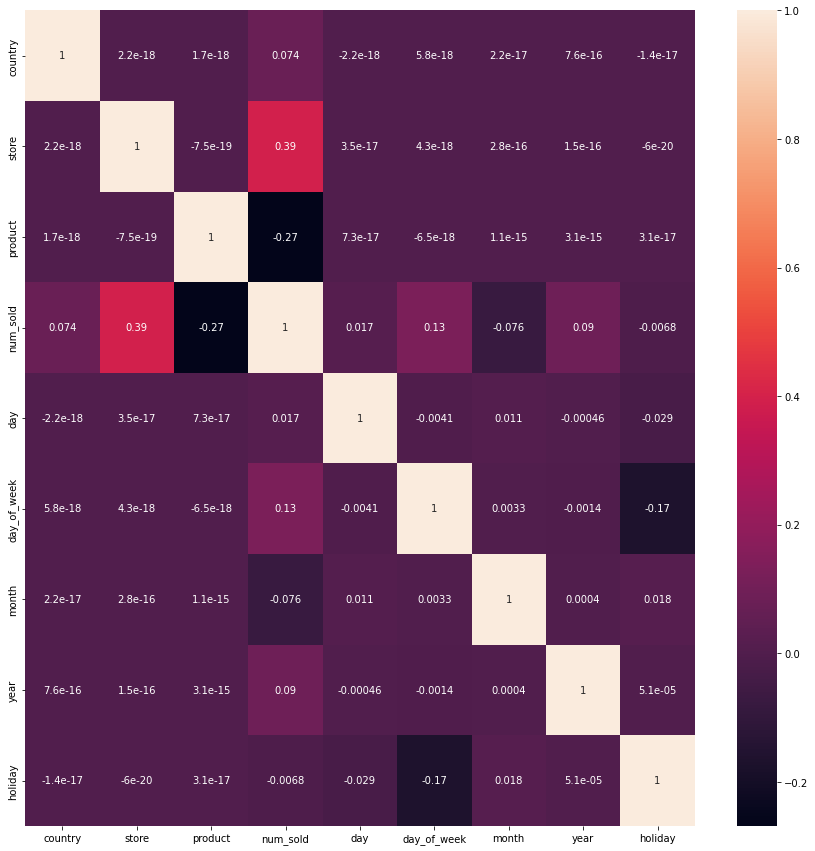

In [13]:
ax, fig = plt.subplots(figsize=(15, 15))
sns.heatmap(df_train.corr(), annot=True)

In [14]:
def smape(target, predicted):
    return 100/len(target) * np.sum(2 * np.abs(predicted - target) / (np.abs(target) + np.abs(predicted)))

In [21]:
def lgb_run(data):
    models = []
    full_preds = np.zeros(len(data))
    kfold = KFold(n_splits=5, random_state=0, shuffle=True)
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(data.drop('num_sold', axis=1), data['num_sold'])):
        x_train, y_train = data.loc[trn_ind].drop('num_sold', axis=1), data.loc[trn_ind, 'num_sold']
        x_val, y_val = data.loc[val_ind].drop('num_sold', axis=1), data.loc[val_ind, 'num_sold']

        model = LGBMRegressor()
        model.fit(x_train, y_train)
        predictions = model.predict(x_val)
        full_preds[y_val.index] = predictions
        models.append(model)
    print(f'MAPE: {mean_absolute_percentage_error(full_preds, data["num_sold"])}')
    print(f'SMAPE: {smape(full_preds, data["num_sold"])}')
    ax = lgb.plot_importance(models[-1], max_num_features=40, figsize=(15,15))
    plt.show()
    return models

MAPE: 0.052332439081954334
SMAPE: 5.236021052873767


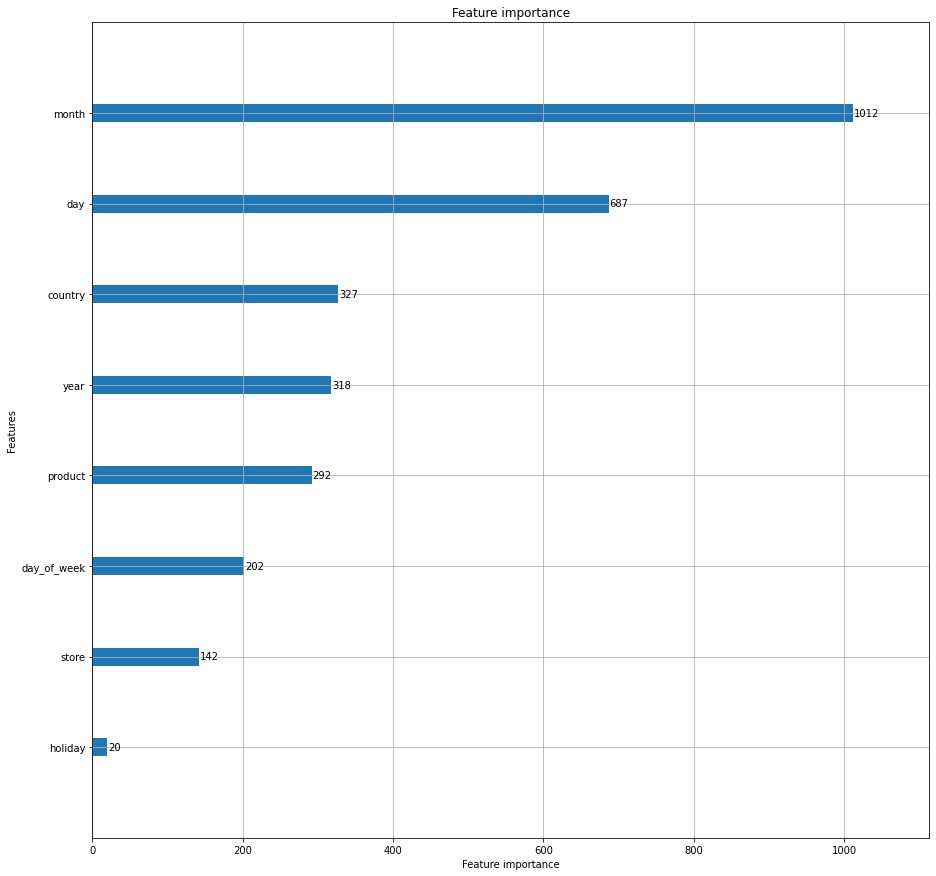

In [22]:
models = lgb_run(df_train)

In [26]:
test_preds = np.zeros(len(df_test))
for model in models:
    test_preds = test_preds + model.predict(df_test)
test_preds /= len(models)
test_preds

array([ 374.46850548,  550.02730912,  172.2255213 , ...,  951.45997371,
       1465.34732565,  358.81523775])

In [28]:
# This gave me 7.16823 score
submission['num_sold'] = test_preds
submission.to_csv('submission.csv', index=False)

/tmp/ipykernel_39044/1555467596.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['num_sold'] = test_preds


In [32]:
preds = np.zeros(len(df_train))
for model in models:
    preds += model.predict(df_train.drop('num_sold', axis=1))
preds /= len(models)
preds

array([ 336.25053606,  494.39566626,  155.54565083, ...,  951.45997371,
       1465.34732565,  358.81523775])

In [33]:
smape(df_train['num_sold'], preds)

4.9474901877782065